In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv('/Users/jamikapage/Library/Mobile Documents/com~apple~CloudDocs/Portfolio/Healthcare Statisfaction Analysis/HCAHPS-Hospital.csv')

In [ ]:
print(df.isnull().sum())

In [ ]:
for col in ['Patient Survey Star Rating Footnote', 'HCAHPS Answer Percent Footnote', 
            'Number of Completed Surveys Footnote', 'Survey Response Rate Percent Footnote']:
    print(f"\nUnique values in {col}:")
    print(df[col].unique())

In [ ]:
# Focus on footnote columns which have mixed types
footnote_columns = [
    'Patient Survey Star Rating Footnote',
    'HCAHPS Answer Percent Footnote',
    'Number of Completed Surveys Footnote',
    'Survey Response Rate Percent Footnote'
]

In [ ]:
footnote_meanings = {
    1: "The number of cases/patients is too few to report.",
    3: "Results are based on a shorter time period than required.",
    5: "Results are not available for this reporting period.",
    6: "Fewer than 100 patients completed the HCAHPS survey. Use these scores with caution.",
    10: "Very few patients were eligible for the HCAHPS survey. The scores shown reflect fewer than 50 completed surveys.",
    11: "There were discrepancies in the data collection process.",
    15: "The number of cases/patients is too few to report a star rating.",
    19: "Data are shown only for hospitals that participate in the Inpatient Quality Reporting (IQR) and Outpatient Quality Reporting (OQR) programs.",
    24: "This value was calculated using data reported by the hospital in compliance with the requirements outlined for this program and does not take into account information that became available at a later date.",
    28: "The results are based on the hospital or facility's data submissions. CMS approved the hospital or facility's Extraordinary Circumstances Exception request suggesting that results may be impacted.",
}

In [ ]:
# Function to clean and split footnotes
def clean_footnotes(value):
    # Check if value is a list or array and handle it explicitly
    if isinstance(value, (list, np.ndarray)):
        if len(value) == 0:  # If the array/list is empty, return an empty list
            return []
        else:
            return value  # If it's a valid array/list, you might want to return it as is or process further

    # Safely check for missing values in non-list objects
    if pd.isna(value):
        return []

    # If the value is a numeric type (int or float)
    if isinstance(value, (int, float)):
        return [int(value)]

    # If the value is a string with multiple comma-separated footnotes
    if isinstance(value, str):
        try:
            return [int(float(v.strip())) for v in value.split(',') if v.strip()]
        except ValueError:
            return []  # Return empty list if conversion fails

    # Default case: return empty list if value is of an unexpected type
    return []

In [ ]:
# Apply cleaning to footnote columns using .loc to avoid warnings
for col in footnote_columns:
    df.loc[:, col] = df[col].apply(clean_footnotes)

In [ ]:
def get_footnote_meanings(footnote):
    # Check if the value is a list or array and handle accordingly
    if isinstance(footnote, (list, np.ndarray)):
        if len(footnote) == 0:
            return "No footnote"
        else:
            return ', '.join([footnote_meanings.get(f, f"Unknown footnote: {f}") for f in footnote])
    
    # Safely check for missing values for non-list objects
    if pd.isna(footnote):
        return "No footnote"
    
    # If the footnote is a string containing multiple values
    if isinstance(footnote, str) and ',' in footnote:
        try:
            footnotes = [int(float(f.strip())) for f in footnote.split(',')]
            return ', '.join([footnote_meanings.get(f, f"Unknown footnote: {f}") for f in footnotes])
        except ValueError:
            return "Invalid footnote format"
    
    # If the footnote is a single number (float or int)
    try:
        footnote = int(float(footnote))
        return footnote_meanings.get(footnote, f"Unknown footnote: {footnote}")
    except (ValueError, TypeError):
        return f"Invalid footnote: {footnote}"


In [ ]:
# Apply to get meanings
for col in footnote_columns:
    df[f'{col}_meanings'] = df[col].apply(get_footnote_meanings)

In [ ]:
# Analyze distribution of footnotes
for col in footnote_columns:
    print(f"\nDistribution of footnote meanings in {col}:")
    print(df[f'{col}_meanings'].value_counts())

In [ ]:
def plot_footnote_distribution(df, column):
    footnotes = [item for sublist in df[column] for item in sublist]
    footnote_counts = pd.Series(footnotes).value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    footnote_counts.plot(kind='bar')
    plt.title(f'Distribution of Footnotes in {column}')
    plt.xlabel('Footnote')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

for col in footnote_columns:
    plot_footnote_distribution(df, col)

In [ ]:
df.info()

In [ ]:
df.describe(include='all')

In [ ]:
# Basic statistics for numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
object_columns = df.select_dtypes(include=[object])
print("Summary for numeric columns:")
print(df[numeric_columns].describe())
print("\nSummary for object columns:")
print(object_columns.describe())

/Volumes/ROSE/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


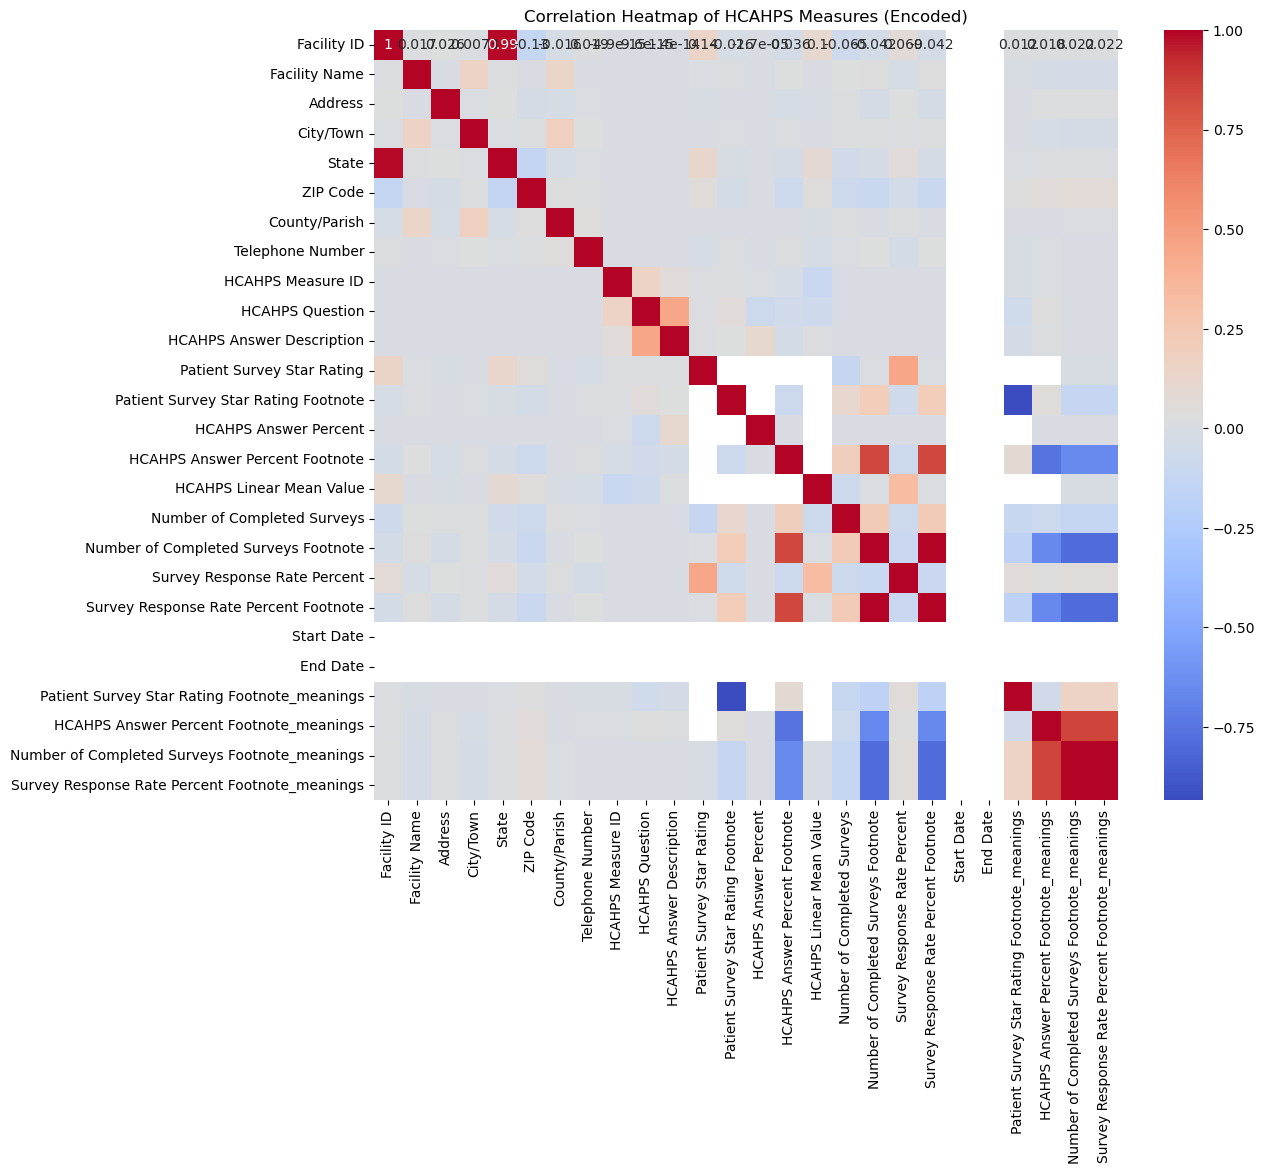

In [48]:
# Make a copy of the DataFrame to avoid changing the original data
df_encoded = df.copy()

# Apply Label Encoding to all object columns
label_encoders = {}
for col in df_encoded.select_dtypes(include=[object]).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))  # Convert to string first to handle any mixed types
    label_encoders[col] = le  # Store the encoder for future reference if needed

# Now df_encoded contains numeric representations of all the object columns

# Calculate the correlation matrix for the encoded data
correlation_matrix = df_encoded.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of HCAHPS Measures (Encoded)')
plt.show()


In [ ]:
# Step 5: Data Visualization

In [ ]:
# Convert relevant columns to numeric, setting errors='coerce' to handle non-numeric values
df['Patient Survey Star Rating'] = pd.to_numeric(df['Patient Survey Star Rating'], errors='coerce')
df['HCAHPS Answer Percent'] = pd.to_numeric(df['HCAHPS Answer Percent'], errors='coerce')
df['HCAHPS Linear Mean Value'] = pd.to_numeric(df['HCAHPS Linear Mean Value'], errors='coerce')
df['Number of Completed Surveys'] = pd.to_numeric(df['Number of Completed Surveys'], errors='coerce')
df['Survey Response Rate Percent'] = pd.to_numeric(df['Survey Response Rate Percent'], errors='coerce')

In [ ]:
print(df[['Patient Survey Star Rating', 'HCAHPS Answer Percent', 'HCAHPS Linear Mean Value']].head())

In [ ]:
# Bar chart of average overall hospital ratings by state
# Group by 'State' and calculate the mean Patient Survey Star Rating
state_ratings = df.groupby('State')['Patient Survey Star Rating'].mean().sort_values(ascending=False)

# Plot the bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
state_ratings.plot(kind='bar')
plt.title('Average Patient Survey Star Rating by State')
plt.xlabel('State')
plt.ylabel('Average Patient Survey Star Rating')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Scatter plot of nurse communication vs overall rating
# Convert the necessary columns to numeric using .loc to avoid the SettingWithCopyWarning
nurse_communication_df.loc[:, 'Patient Survey Star Rating'] = pd.to_numeric(nurse_communication_df['Patient Survey Star Rating'], errors='coerce')

# Scatter plot of nurse communication score vs overall hospital rating
plt.figure(figsize=(10, 6))
plt.scatter(nurse_communication_df['HCAHPS Linear Mean Value'], nurse_communication_df['Patient Survey Star Rating'])
plt.title('Nurse Communication vs Overall Hospital Rating')
plt.xlabel('Nurse Communication Score')
plt.ylabel('Overall Hospital Rating')
plt.show()

In [ ]:
# Check if the filtered DataFrame has data
print("Filtered DataFrame shape:", nurse_communication_df.shape)
print(nurse_communication_df[['HCAHPS Linear Mean Value', 'Patient Survey Star Rating']].head())

In [ ]:
# Check the first few rows of the relevant columns in the original DataFrame
print(df[['HCAHPS Linear Mean Value', 'Patient Survey Star Rating']].head(20))

In [ ]:
# Filter out rows where both 'HCAHPS Linear Mean Value' and 'Patient Survey Star Rating' are not NaN
valid_data = nurse_communication_df.dropna(subset=['HCAHPS Linear Mean Value', 'Patient Survey Star Rating'])

# Check how many valid rows we have
print("Valid data shape:", valid_data.shape)

In [ ]:
# Scatter plot of nurse communication score vs overall hospital rating with valid data
plt.figure(figsize=(10, 6))
plt.scatter(valid_data['HCAHPS Linear Mean Value'], valid_data['Patient Survey Star Rating'])
plt.title('Nurse Communication vs Overall Hospital Rating')
plt.xlabel('Nurse Communication Score')
plt.ylabel('Overall Hospital Rating')
plt.show()

In [ ]:
# Check for non-NaN data in related columns
print("Unique values in 'HCAHPS Answer Percent':", df['HCAHPS Answer Percent'].unique())
print("Unique values in 'Survey Response Rate Percent':", df['Survey Response Rate Percent'].unique())

In [ ]:
# Convert 'Patient Survey Star Rating' to numeric if not already
df['Patient Survey Star Rating'] = pd.to_numeric(df['Patient Survey Star Rating'], errors='coerce')

# Filter rows where 'HCAHPS Answer Percent' and 'Patient Survey Star Rating' are not NaN
valid_data_answer_percent = df.dropna(subset=['HCAHPS Answer Percent', 'Patient Survey Star Rating'])

# Plot scatter plot of HCAHPS Answer Percent vs Patient Survey Star Rating
plt.figure(figsize=(10, 6))
plt.scatter(valid_data_answer_percent['HCAHPS Answer Percent'], valid_data_answer_percent['Patient Survey Star Rating'])
plt.title('HCAHPS Answer Percent vs Overall Hospital Rating')
plt.xlabel('HCAHPS Answer Percent')
plt.ylabel('Overall Hospital Rating')
plt.show()


In [ ]:
# Filter rows where 'Survey Response Rate Percent' and 'Patient Survey Star Rating' are not NaN
valid_data_response_rate = df.dropna(subset=['Survey Response Rate Percent', 'Patient Survey Star Rating'])

# Plot scatter plot of Survey Response Rate Percent vs Patient Survey Star Rating
plt.figure(figsize=(10, 6))
plt.scatter(valid_data_response_rate['Survey Response Rate Percent'], valid_data_response_rate['Patient Survey Star Rating'])
plt.title('Survey Response Rate Percent vs Overall Hospital Rating')
plt.xlabel('Survey Response Rate Percent')
plt.ylabel('Overall Hospital Rating')
plt.show()

In [ ]:
# Step 6: Advanced Analysis

In [ ]:
# Example: Analyze impact of footnotes on ratings
for col in footnote_columns:
    plt.figure(figsize=(12, 6))
    df.boxplot(column='Patient Survey Star Rating ', by=f'{col}_meanings')
    plt.title(f'Impact of {col} on HCAHPS Base Score')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
# Convert columns to numeric, handling errors by converting invalid values to NaN
df['HCAHPS Linear Mean Value'] = pd.to_numeric(df['HCAHPS Linear Mean Value'], errors='coerce')
df['Patient Survey Star Rating'] = pd.to_numeric(df['Patient Survey Star Rating'], errors='coerce')

In [ ]:
# Generate a boxplot for 'HCAHPS Linear Mean Value' by footnote meanings
for col in footnote_columns:
    plt.figure(figsize=(12, 6))
    df.boxplot(column='HCAHPS Linear Mean Value', by=f'{col}_meanings')
    plt.title(f'Impact of {col} on HCAHPS Linear Mean Value')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
# Check how many non-NaN values are in both columns
print(df[['Patient Survey Star Rating', 'HCAHPS Linear Mean Value']].notna().sum())

In [ ]:
# Check the first few rows of the numeric columns
print(df[['Patient Survey Star Rating', 'HCAHPS Linear Mean Value']].head(10))

In [ ]:
# Drop rows with NaN in either 'Patient Survey Star Rating' or 'HCAHPS Linear Mean Value'
df_clean = df.dropna(subset=['Patient Survey Star Rating', 'HCAHPS Linear Mean Value'])

# Check the number of rows remaining
print(df_clean.shape)  # This will tell you how many rows remain after cleaning

In [ ]:
# Ensure there are valid rows after cleaning
if df_clean.empty:
    print("No valid data to train the model.")
else:
    # Define the feature (X) and target (y)
    X_clean = df_clean[['Patient Survey Star Rating']]
    y_clean = df_clean['HCAHPS Linear Mean Value']
    
    # Split the data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

    # Train a linear regression model
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions and evaluate the model
    y_pred = model.predict(X_test)
    from sklearn.metrics import r2_score
    print(f'R^2 score: {r2_score(y_test, y_pred)}')


In [ ]:
# Convert 'HCAHPS Answer Percent' and 'HCAHPS Linear Mean Value' to numeric
df['HCAHPS Answer Percent'] = pd.to_numeric(df['HCAHPS Answer Percent'], errors='coerce')
df['HCAHPS Linear Mean Value'] = pd.to_numeric(df['HCAHPS Linear Mean Value'], errors='coerce')

In [ ]:
# Fill missing values with the mean for both columns
df['HCAHPS Answer Percent'] = df['HCAHPS Answer Percent'].fillna(df['HCAHPS Answer Percent'].mean())
df['HCAHPS Linear Mean Value'] = df['HCAHPS Linear Mean Value'].fillna(df['HCAHPS Linear Mean Value'].mean())

# Check again for any remaining NaN values
print(df[['HCAHPS Answer Percent', 'HCAHPS Linear Mean Value']].isna().sum())

In [ ]:
# Check the first few rows of the original 'HCAHPS Answer Percent' and 'HCAHPS Linear Mean Value' columns
print(df[['HCAHPS Answer Percent', 'HCAHPS Linear Mean Value']].head(10))

# Check unique values in these columns to identify any non-numeric or problematic entries
print(df['HCAHPS Answer Percent'].unique())
print(df['HCAHPS Linear Mean Value'].unique())

In [ ]:
# Identify top-performing hospitals by 'HCAHPS Linear Mean Value'
top_hospitals = df.nlargest(10, 'HCAHPS Linear Mean Value')

# Display the top 10 hospitals based on 'HCAHPS Linear Mean Value'
print("\nTop 10 Hospitals by HCAHPS Linear Mean Value:")
print(top_hospitals[['Facility Name', 'State', 'HCAHPS Linear Mean Value']])

In [ ]:
# Convert potential numeric columns to numeric types
numeric_columns = ['Survey Response Rate Percent', 'HCAHPS Answer Percent', 'HCAHPS Linear Mean Value']  # Add any other columns you think should be numeric

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert, and turn errors into NaN

In [ ]:
# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=['Facility Name'], drop_first=True)

In [ ]:
# Drop rows with NaN values in relevant columns
df_clean = df_encoded.dropna(subset=['Survey Response Rate Percent'])

In [ ]:
# Define features (X) and target (y)
X = df_clean.drop(columns=['Survey Response Rate Percent'])  # All columns except the target
y = df_clean['Survey Response Rate Percent']  # The target column

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'R² score: {r2}')

In [ ]:
df_clean = df.dropna(subset=['HCAHPS Linear Mean Value', 'HCAHPS Answer Percent'])

In [ ]:
# Replace non-numeric values with NaN for 'HCAHPS Answer Percent' and 'HCAHPS Linear Mean Value'
df_clean['HCAHPS Answer Percent'] = pd.to_numeric(df_clean['HCAHPS Answer Percent'], errors='coerce')
df_clean['HCAHPS Linear Mean Value'] = pd.to_numeric(df_clean['HCAHPS Linear Mean Value'], errors='coerce')

In [ ]:
# Now perform aggregation after cleaning
df_aggregated = df_clean.groupby('Facility Name').agg({
    'HCAHPS Answer Percent': 'mean',
    'HCAHPS Linear Mean Value': 'mean',
    'State': 'first'  # Keep the first state
}).reset_index()

In [ ]:
# Choropleth map of hospital ratings using aggregated data
fig = px.choropleth(df_aggregated,
                    locations='State', 
                    color='HCAHPS Linear Mean Value',  # Use the correct column for ratings
                    hover_name='Facility Name',  # Use 'Facility Name' for hover
                    locationmode='USA-states',
                    scope="usa",
                    title='Hospital Ratings Across States')
fig.show()

# Scatter plot: 'HCAHPS Answer Percent' vs 'HCAHPS Linear Mean Value'
fig = px.scatter(df_aggregated, 
                 x='HCAHPS Answer Percent',  # Use 'HCAHPS Answer Percent' as a feature
                 y='HCAHPS Linear Mean Value',  # Use 'HCAHPS Linear Mean Value' as rating
                 hover_data=['Facility Name', 'State'],  # Use 'Facility Name' for hover
                 title='HCAHPS Answer Percent vs Overall Hospital Rating')
fig.show()

In [ ]:
# Step 7: Insights Generation

In [ ]:
# Example: Identify top-performing hospitals
# Convert 'HCAHPS Linear Mean Value' to numeric, handling errors
df_aggregated['HCAHPS Linear Mean Value'] = pd.to_numeric(df_aggregated['HCAHPS Linear Mean Value'], errors='coerce')

# Now find the top 10 hospitals by 'HCAHPS Linear Mean Value'
top_hospitals = df_aggregated.nlargest(10, 'HCAHPS Linear Mean Value')

# Display the top 10 hospitals
print("\nTop 10 Hospitals by HCAHPS Linear Mean Value:")
print(top_hospitals[['Facility Name', 'State', 'HCAHPS Linear Mean Value']])


In [ ]:
# Function to display hospital information with interpretations
def get_hospital_info(hospital_number):
    try:
        if 0 <= hospital_number < len(df):
            hospital_data = df.iloc[hospital_number]

            # Basic hospital info
            print(f"\nAnalysis for Hospital #{hospital_number}:")
            print(f"Facility Name          : {hospital_data.get('Facility Name', 'N/A')}")
            print(f"Address                : {hospital_data.get('Address', 'N/A')}")
            print(f"City/Town              : {hospital_data.get('City/Town', 'N/A')}")
            print(f"State                  : {hospital_data.get('State', 'N/A')}")
            print(f"ZIP Code               : {hospital_data.get('ZIP Code', 'N/A')}")
            print(f"Telephone Number       : {hospital_data.get('Telephone Number', 'N/A')}")

            # Survey and ratings info
            print(f"\nHCAHPS Measure         : {hospital_data.get('HCAHPS Measure ID', 'N/A')}")
            print(f"HCAHPS Question        : {hospital_data.get('HCAHPS Question', 'N/A')}")
            print(f"Patient Survey Rating  : {hospital_data.get('Patient Survey Star Rating', 'N/A')}")
            print(f"HCAHPS Answer Percent  : {hospital_data.get('HCAHPS Answer Percent', 'N/A')}%")
            print(f"HCAHPS Linear Mean     : {hospital_data.get('HCAHPS Linear Mean Value', 'N/A')}")
            print(f"Completed Surveys      : {hospital_data.get('Number of Completed Surveys', 'N/A')}")
            print(f"Survey Response Rate   : {hospital_data.get('Survey Response Rate Percent', 'N/A')}%")

            # Interpretations based on the data
            try:
                survey_star_rating = float(hospital_data.get('Patient Survey Star Rating', np.nan))
                response_rate = float(hospital_data.get('Survey Response Rate Percent', np.nan))
                answer_percent = float(hospital_data.get('HCAHPS Answer Percent', np.nan))
                
                # Compare hospital rating and response rate with thresholds
                if survey_star_rating >= 4:
                    print("\n💡 Interpretation: This hospital has a high patient satisfaction rating (4 stars or higher).")
                elif survey_star_rating < 3:
                    print("\n💡 Interpretation: This hospital has a low patient satisfaction rating (below 3 stars).")

                # Evaluate response rate
                if response_rate < 20:
                    print("⚠️ The survey response rate is low (below 20%). This might affect the reliability of the data.")
                elif response_rate > 50:
                    print("👍 The survey response rate is good (above 50%). This suggests a reliable representation of patient opinions.")
                
                # Suggest further analysis
                if survey_star_rating < 3 and response_rate < 20:
                    print("💭 Could the low response rate be linked to the lower satisfaction rating?")
                
                if answer_percent < 50:
                    print("⚠️ The percentage of positive answers (HCAHPS Answer Percent) is below 50%. This indicates room for improvement.")
                else:
                    print("👍 The majority of patients provided positive answers (HCAHPS Answer Percent above 50%).")
            
            except ValueError:
                print("🔍 Not enough data for detailed analysis on survey star rating or response rate.")

            # Display footnotes if present
            footnote_columns = ['Patient Survey Star Rating Footnote', 'HCAHPS Answer Percent Footnote', 
                                'Number of Completed Surveys Footnote', 'Survey Response Rate Percent Footnote']
            for col in footnote_columns:
                if pd.notna(hospital_data.get(col)):  # Check if the footnote exists
                    print(f"\n{col}: {hospital_data[col]}")
                    print(f"Meaning: {hospital_data.get(f'{col}_meanings', 'No meaning available')}")
        else:
            print(f"\nNo hospital found with number {hospital_number}.")
            print(f"Valid hospital numbers are 0 to {len(df) - 1}")
    
    except Exception as e:
        print(f"An error occurred: {e}")

# Loop to get user input
def prompt_hospital_lookup():
    while True:
        try:
            hospital_number = int(input("\nEnter a hospital number (or -1 to exit): "))
            if hospital_number == -1:
                print("Exiting the program.")
                break
            get_hospital_info(hospital_number)
        except ValueError:
            print("Please enter a valid number.")

# Run the hospital lookup prompt
prompt_hospital_lookup()


In [ ]:
# Step 8: Prepare for GitHub

In [ ]:
# Save cleaned data
df.to_csv('cleaned_HCAHPS_data.csv', index=False)

# Save visualizations
plt.savefig('correlation_heatmap.png')
plt.savefig('state_ratings_bar_chart.png')
plt.savefig('nurse_communication_scatter.png')